# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.4.0'

In [3]:
tf.keras.__version__

'2.4.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

In [4]:
from keras.datasets import cifar10
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')

# resnet preprocess
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train.shape[0])
X_valid, X_train = X_train[shuffled_indices[:5000]], X_train[shuffled_indices[5000:]]
y_valid, y_train = y_train[shuffled_indices[:5000]], y_train[shuffled_indices[5000:]]

# data augmentation
datagen = ImageDataGenerator(
		rotation_range=40,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

train_data_generator = datagen.flow(X_train, y_train, batch_size=32)

## Build and train the model

Build and train your model. 

In [5]:
resNet50_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(256, 256, 3), weights='imagenet')

In [6]:
# show the structure of your model
resNet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
model = keras.models.Sequential()

# upsampling is needed because Resnet50 works best with images greater than 200 x 200
model.add(keras.layers.UpSampling2D((8,8))) # Size 256 x 256

model.add(resNet50_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='softmax'))

# Freeze the resNet50 layers but retrain the last block
for layer in resNet50_model.layers[:-32]:
  layer.trainable = False

In [8]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
history = model.fit(train_data_generator, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1407/1407 [==============================] - 410s 287ms/step - loss: 1.5843 - accuracy: 0.4761 - val_loss: 0.6510 - val_accuracy: 0.7950
Epoch 2/10
1407/1407 [==============================] - 403s 286ms/step - loss: 0.8694 - accuracy: 0.7073 - val_loss: 0.5069 - val_accuracy: 0.8374
Epoch 3/10
1407/1407 [==============================] - 403s 287ms/step - loss: 0.7213 - accuracy: 0.7618 - val_loss: 0.4505 - val_accuracy: 0.8572
Epoch 4/10
1407/1407 [==============================] - 403s 287ms/step - loss: 0.6264 - accuracy: 0.7978 - val_loss: 0.4236 - val_accuracy: 0.8684
Epoch 5/10
1407/1407 [==============================] - 403s 287ms/step - loss: 0.5664 - accuracy: 0.8164 - val_loss: 0.3558 - val_accuracy: 0.8864
Epoch 6/10
1407/1407 [==============================] - 403s 286ms/step - loss: 0.5204 - accuracy: 0.8307 - val_loss: 0.3999 - val_accuracy: 0.8800
Epoch 7/10
1407/1407 [==============================] - 403s 287ms/step - loss: 0.4764 - accuracy: 0.8454 - val_

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, None, None, None)  0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               67109376  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6

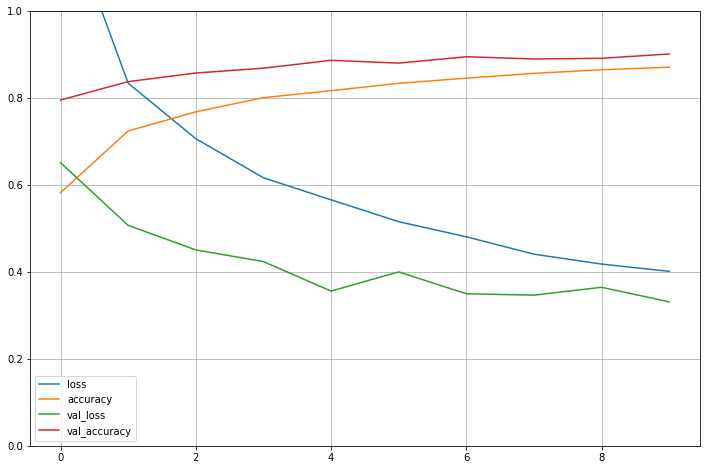

In [11]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [12]:
model.save('cifar10.h5') 

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
model.save(F"/content/gdrive/My Drive/cifar10.h5") 

## Load the model and evaluate it on the test data

In [15]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 55s 174ms/step - loss: 0.3481 - accuracy: 0.8981


[0.3481239974498749, 0.8981000185012817]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

The main challenges with this task were the following:
- Picking a model to optimize and use Transfer Learning in order to adapt to the data accordingly
- The size of the model, which made it difficult to use a method such as Hyperas (takes to much time). Therefore optimizing the model had to be more focused on specific parts
- Having enough data to train and test the model

In order to tackle these challenges we performed the following:
- Picking a model: From the Keras library we decided to pick a model which does not have a too big size (Amount of parameters to train). Which is why we eventually ended up choosing ResNet50. The model also had a reasonably good performance which is why we went with this option.
- Having enough Data to optimize the model: The provided dataset was relatively small. However, in order to optimize a neural network we would need a relatively high amount of data so that the model can fine tune its parameters. In order to increase the amount of data we therefore used data augumentation, this means we artificially created new data based on the properties of the existing data which would serve as the training data. After increasing the amount of data directly we applied the augumented data set to train our model by using the keras library ImageDataGenerator.
- Understanding how to optimize the Model: For this we had to perform research in related literature, where we noted that:
    - optimizing a model of large scale requires to train the model at certain layers rather than training all layers and neurons of a network. For this purpose we different numbers of layers to freeze while the remaining layers were optimized similar to the Hyperas method as done in the first part of the exercise. After some trials we figured out that we should train only the last 32 layers of the model, which did not consume significant amount of time in order to fine tune the model parameters (neurons, layers, activation functions per layer etc.)
    - The size of the model vs. the size of the input values represented a problem as the input values were not large enough for the model to increase its performance. As such we had to perform so-called upscaling. Without upscaling our model did not quite reach the accuracy as high as required. Upscaling is used in order to artificially increase the size of a certain data point in the testing set. i.e. in this case the size of a picture had to be increased to enhance the performance of the model. After which we could see an improvement in accuracy.
    - As we have removed ResNet50's fully connected layer, we tried to add our own fully connected layers on top of the existing model. Starting with only one hidden layer with just 128 neurons showed not promising results: The model was clearly underfitting reaching only an test accuracy of 60%. We started by adding another hidden layer and in addition to that added a normalization layer and a dropout layer to each of the hidden layers to prevent overfitting.

After applying all these steps we finally reached a test accuracy of 89%.